In [29]:
import pandas as pd
import numpy as np

column_names_full = [
    "track_id", "race_date", "race_number", "program_number",
    "trakus_index", "latitude", "longitude", "distance_id",
    "course_type", "track_condition", "run_up_distance", 
    "race_type", "post_time", "weight_carried", "jockey", 
    "odds", "position_at_finish"
]

column_names_desired = [
    "race_date", "race_number", "program_number", "trakus_index", "latitude", "longitude", "distance_id", "course_type", "track_condition",
    "race_type", "weight_carried", "jockey", 
    "odds", "position_at_finish"
]

# Load the dataset
df = pd.read_csv("nyra_2019_complete.csv", header=None, usecols=[1,2,3,4,5,6,7,8,9,11,14,15,16,17], names=column_names_desired)[column_names_desired]

# Inspect the data
df.info()
df.head()

C:\Users\ahmet\AppData\Local\Temp\ipykernel_15200\3901139008.py:19: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("nyra_2019_complete.csv", header=None, usecols=[1,2,3,4,5,6,7,8,9,11,14,15,16,17], names=column_names_desired)[column_names_desired]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5228430 entries, 0 to 5228429
Data columns (total 14 columns):
 #   Column              Dtype  
---  ------              -----  
 0   race_date           object 
 1   race_number         int64  
 2   program_number      object 
 3   trakus_index        int64  
 4   latitude            float64
 5   longitude           float64
 6   distance_id         int64  
 7   course_type         object 
 8   track_condition     object 
 9   race_type           object 
 10  weight_carried      int64  
 11  jockey              object 
 12  odds                int64  
 13  position_at_finish  int64  
dtypes: float64(2), int64(6), object(6)
memory usage: 558.5+ MB


,race_date,race_number,program_number,trakus_index,latitude,longitude,distance_id,course_type,track_condition,race_type,weight_carried,jockey,odds,position_at_finish
0,2019-01-01,9,6,72,40.672902,-73.827607,600,D,GD,CLM,120,Andre Shivnarine Worrie,2090,8
1,2019-01-01,9,6,73,40.672946,-73.827587,600,D,GD,CLM,120,Andre Shivnarine Worrie,2090,8
2,2019-01-01,9,6,74,40.672990,-73.827568,600,D,GD,CLM,120,Andre Shivnarine Worrie,2090,8
3,2019-01-01,9,6,63,40.672510,-73.827781,600,D,GD,CLM,120,Andre Shivnarine Worrie,2090,8
4,2019-01-01,9,6,64,40.672553,-73.827762,600,D,GD,CLM,120,Andre Shivnarine Worrie,2090,8


In [31]:
# Preprocessing
# ---
# Dropping nulls
df = df.dropna(axis=0)

# Getting only a fraction of the total data for easier computation.
df = df.sample(frac=0.5, random_state=42)

# Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['distance_id', 'weight_carried', 'odds']] = scaler.fit_transform(df[['distance_id', 'weight_carried', 'odds']])

# Scaled columns
df.head()[['distance_id', 'weight_carried', 'odds']]

,distance_id,weight_carried,odds
3350553,0.290323,0.20,0.021990
2424821,0.096774,0.06,0.030366
3572973,0.129032,0.20,0.021990
3809994,0.258065,0.20,0.092670
992396,0.290323,0.16,0.094764


In [39]:
# Feature Engineering Preparation

# Defining the Haversine formula for calculating the distance using the latitude and longitude data available.
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c * 1000  # Convert to meters

In [43]:
# Feature Engineering 
    # Engineering the following Features related to positions:
        # Positional change
        # Pace consistency
        # Position difference relative to other competitors
        # Positional stability
        # Expected Finnish positionm
        # Late-race performance

df = df.sort_values(by='race_date')

# Calculate distance for each horse at each trakus_index
# Trakus index is the common collection of point of the lat / long of the horse in the race passed as an integer, collected every 0.25 seconds
df['lat_shift'] = df.groupby('program_number')['latitude'].shift(1)
df['lon_shift'] = df.groupby('program_number')['longitude'].shift(1)

df['distance_traveled'] = haversine(
    df['latitude'], df['longitude'], df['lat_shift'], df['lon_shift']
)

df['distance_traveled'] = df['distance_traveled'].fillna(0)

# Cumulative distance, to be used for comparison later
df['cumulative_distance'] = df.groupby('program_number')['distance_traveled'].transform('cumsum')

# Calculate time difference in seconds in between each trakus record
df['time_diff'] = df.groupby('program_number')['trakus_index'].diff().fillna(0) * 0.25

# Calculate speed and acceleration using the previously calculated distance and time differences
df['speed'] = df['distance_traveled'] / df['time_diff'].replace(0, np.nan).fillna(0)
df['acceleration'] = df.groupby('program_number')['speed'].diff().fillna(0) / df['time_diff']

df['speed'] = df['speed'].replace([np.inf, -np.inf], 0).fillna(0)
df['acceleration'] = df['acceleration'].replace([np.inf, -np.inf], 0).fillna(0)

# Rank horses based on cumulative distance at each trakus_index
df['relative_position'] = df.groupby('trakus_index')['cumulative_distance'].rank(ascending=False, method='min')

# Define the last 10% of trakus_index as the final stage
max_trakus = df['trakus_index'].max()
final_stage_start = int(max_trakus * 0.9)

# Calculate features specific to the final stage
final_stage_mask = df['trakus_index'] >= final_stage_start
df['final_stage_position_change'] = 0 
df.loc[final_stage_mask, 'final_stage_position_change'] = df.loc[
    final_stage_mask
].groupby('program_number')['relative_position'].diff().fillna(0)

df['final_stage_position_change'] = df['final_stage_position_change'].fillna(0)

# Mean rank during the race as a proxy for expected position
df['expected_position'] = df.groupby('program_number')['relative_position'].transform('mean')

df['expected_position'] = df['expected_position'].replace([np.inf, -np.inf], 0).fillna(0)

# Scaling the new features
df[['expected_position', 'final_stage_position_change', 'speed', 'acceleration']] = scaler.fit_transform(df[['expected_position', 'final_stage_position_change', 'speed', 'acceleration']])

# Added and scaled features
df.head()[['expected_position', 'final_stage_position_change', 'speed', 'acceleration']]

,expected_position,final_stage_position_change,speed,acceleration
2436454,0.000000,0.47619,0.666443,0.027026
406947,0.656672,0.47619,0.666443,0.027026
1278402,0.553169,0.47619,0.666443,0.027026
4011954,0.431884,0.47619,0.666443,0.027026
2324713,0.321378,0.47619,0.666443,0.027026


In [45]:
# Feature Engineering 
    # Engineering the following Features:
        # Jockey influence
        # Horse's relative performance on specific track types
        # Horse's relative performance on specific course types
        # Horse's relative performance on specific race types

# Mean finishing position of each jockey
df['jockey_score'] = (
    df.groupby('jockey')['position_at_finish']
    .expanding()
    .mean()
    .shift(1)
    .reset_index(level=0, drop=True)
)

global_mean_jockey = df['jockey_score'].mean()
df['jockey_score'] = df['jockey_score'].fillna(global_mean_jockey)

# Calculate horse_track_relative_score, in a cumulative manner to prevent data leakage.
# This feature combines the horse's overall mean finish position and horse's track-specific mean finish position 
# for capturing the relationship in between.
df['horse_track_relative_score'] = (
    df.groupby(['program_number', 'track_condition'])['position_at_finish']
    .expanding()
    .mean()
    .shift(1)
    .reset_index(level=[0, 1], drop=True)  # Horse track score
) / (
    df.groupby('program_number')['position_at_finish']
    .expanding()
    .mean()
    .shift(1)
    .reset_index(level=0, drop=True)  # Horse score
)

# Calculate horse_course_relative_score, in a cumulative manner to prevent data leakage.
# This feature combines the horse's overall mean finish position and horse's course type-specific mean finish position 
# for capturing the relationship in between.
df['horse_course_relative_score'] = (
    df.groupby(['program_number', 'course_type'])['position_at_finish']
    .expanding()
    .mean()
    .shift(1)
    .reset_index(level=[0, 1], drop=True)  # Horse course score
) / (
    df.groupby('program_number')['position_at_finish']
    .expanding()
    .mean()
    .shift(1)
    .reset_index(level=0, drop=True)  # Horse score
)

# Calculate horse_course_relative_score, in a cumulative manner to prevent data leakage.
# This feature combines the horse's overall mean finish position and horse's race type-specific mean finish position 
# for capturing the relationship in between.
df['horse_race_relative_score'] = (
    df.groupby(['program_number', 'race_type'])['position_at_finish']
    .expanding()
    .mean()
    .shift(1)
    .reset_index(level=[0, 1], drop=True)  # Horse race score
) / (
    df.groupby('program_number')['position_at_finish']
    .expanding()
    .mean()
    .shift(1)
    .reset_index(level=0, drop=True)  # Horse score
)

# Scaling the new features
df[['jockey_score', 'horse_track_relative_score', 'horse_course_relative_score', 'horse_race_relative_score']] = scaler.fit_transform(df[['jockey_score', 'horse_track_relative_score', 'horse_course_relative_score', 'horse_race_relative_score']])

# Added and scaled features
df.head()[['jockey_score', 'horse_track_relative_score', 'horse_course_relative_score', 'horse_race_relative_score']]

,jockey_score,horse_track_relative_score,horse_course_relative_score,horse_race_relative_score
2436454,0.447769,0.115411,0.099593,0.101991
406947,0.441207,0.161991,0.099593,0.165873
1278402,0.327301,0.122861,0.101891,0.143988
4011954,0.152401,0.110716,0.117057,0.091622
2324713,0.583333,0.109477,0.105638,0.097385


In [47]:
# Correlation matrix
correlations = df[['expected_position', 'final_stage_position_change', 'speed', 'acceleration', 'jockey_score', 'horse_track_relative_score', 
                   'horse_course_relative_score', 'horse_race_relative_score']].corr()
print(correlations)

# Correlations are weak, indicating that all added features are meaningful.

                             expected_position  final_stage_position_change  \
expected_position                     1.000000                 1.910202e-04   
final_stage_position_change           0.000191                 1.000000e+00   
speed                                -0.000946                 6.035051e-06   
acceleration                         -0.004528                -5.234550e-07   
jockey_score                          0.033215                -2.066870e-04   
horse_track_relative_score           -0.016880                -1.032122e-04   
horse_course_relative_score           0.016361                -1.217026e-04   
horse_race_relative_score             0.005535                -1.295066e-04   

                                speed  acceleration  jockey_score  \
expected_position           -0.000946 -4.527992e-03      0.033215   
final_stage_position_change  0.000006 -5.234550e-07     -0.000207   
speed                        1.000000 -6.970951e-01      0.000480   
acceleration

In [49]:
# Preparing for data split
# Features list
features = [
    'expected_position', 'final_stage_position_change', 'speed', 'acceleration', 'jockey_score', 'horse_track_relative_score', 
    'horse_course_relative_score', 'horse_race_relative_score', 'distance_id', 'weight_carried', 'odds',
]
target = 'position_at_finish'

from sklearn.model_selection import train_test_split

# Data split
X = pd.get_dummies(df[features])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

from sklearn.impute import SimpleImputer

# Fill missing values with the mean
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_train = pd.DataFrame(X_train_imputed, columns=X_train.columns)

imputer = SimpleImputer(strategy='mean')
X_test_imputed = imputer.fit_transform(X_test)
X_test = pd.DataFrame(X_test_imputed, columns=X_test.columns)

# Describe the train data
X_train.describe()

,expected_position,final_stage_position_change,speed,acceleration,jockey_score,horse_track_relative_score,horse_course_relative_score,horse_race_relative_score,distance_id,weight_carried,odds
count,2.091372e+06,2.091372e+06,2.091372e+06,2.091372e+06,2.091372e+06,2.091372e+06,2.091372e+06,2.091372e+06,2.091372e+06,2.091372e+06,2.091372e+06
mean,1.905092e-01,4.761904e-01,6.664426e-01,2.704941e-02,2.711341e-01,1.031869e-01,1.021661e-01,1.005141e-01,1.977356e-01,2.142459e-01,7.764756e-02
std,2.006705e-01,2.454405e-03,5.759007e-04,7.649851e-04,6.716947e-02,1.635580e-02,1.599432e-02,1.809247e-02,1.158946e-01,8.698400e-02,1.022036e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.062605e-03,4.761905e-01,6.664257e-01,2.702662e-02,2.265506e-01,9.628675e-02,9.493025e-02,9.276357e-02,9.677419e-02,1.600000e-01,1.753927e-02
50%,2.351736e-01,4.761905e-01,6.664428e-01,2.702700e-02,2.603883e-01,1.005394e-01,9.959296e-02,1.006765e-01,2.258065e-01,2.000000e-01,3.821990e-02
75%,2.632928e-01,4.761905e-01,6.664599e-01,2.702823e-02,3.025300e-01,1.109160e-01,1.070089e-01,1.086305e-01,2.580645e-01,2.400000e-01,9.109948e-02
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [51]:
# Export processed data with the target to compare

# Export processed data without the target for predictions
X.to_csv("nyra_2019_complete_processed_no_target.csv", index=False)
print("Processed features only data saved to 'nyra_2019_complete_processed_no_target.csv'")

processed_data_with_target = pd.concat([X, y], axis=1)
processed_data_with_target.to_csv("nyra_2019_complete_processed_with_target.csv", index=False)
print("Processed data with target saved to 'nyra_2019_complete_processed_with_target.csv'")

Processed features only data saved to 'nyra_2019_complete_processed_no_target.csv'
Processed data with target saved to 'nyra_2019_complete_processed_with_target.csv'


In [15]:
# Catboost parameter optimization
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'bagging_temperature': [0, 1, 2],
    'border_count': [32, 64]
}

# Initialize CatBoost Regressor
cat_model = CatBoostRegressor(
    random_state=42,
    silent=True  
)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=cat_model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error', 
    cv=3,                              
    verbose=2,
    n_jobs=-1                          
)

grid_search.fit(X_train, y_train)

# Output the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best MAE:", -grid_search.best_score_)


Fitting 3 folds for each of 486 candidates, totalling 1458 fits
Best Parameters: {'bagging_temperature': 0, 'border_count': 64, 'depth': 4, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.01}
Best MAE: 1.7872252318653032


In [53]:
# Training the model with Random Forest
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from catboost import CatBoostRegressor
import joblib

cat_model_file = "horsemodel_catboost.pkl"

# Initialize XGBoost
cat_model = CatBoostRegressor(
    iterations=200,
    learning_rate=0.1,
    depth=6,
    l2_leaf_reg=10,  
    bagging_temperature=1.0,  
    random_state=42,
    silent=True
)
cat_model.fit(X_train, y_train)

# Train the model
cat_model.fit(X_train, y_train)

# Evaluate the model
y_pred = cat_model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")

# Save the model
joblib.dump(cat_model, cat_model_file)

Mean Squared Error (MSE): 3.909237146380908
R² Score: 0.40762226969142246
Mean Absolute Error (MAE): 1.578275384280182


['horsemodel_catboost.pkl']

In [55]:
# Model Evaluation: Comparation to Baseline
baseline_pred = y_test.mean()
baseline_mse = mean_squared_error(y_test, [baseline_pred] * len(y_test))
print("Baseline MSE:", baseline_mse)

Baseline MSE: 6.599230434176743


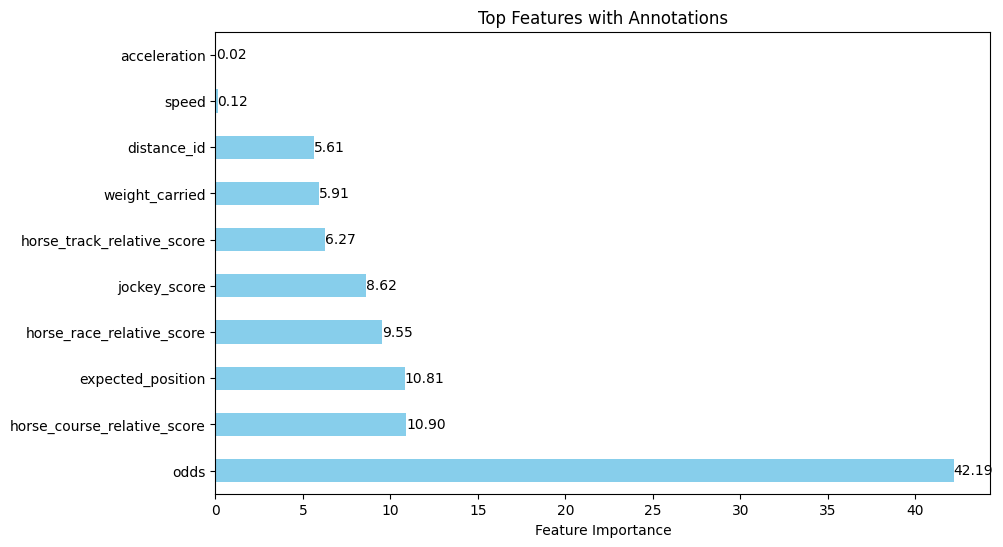

In [57]:
# Model Evaluation - Feature Importance
import matplotlib.pyplot as plt
import pandas as pd

# Sort features by importance
feature_importances = pd.Series(cat_model.feature_importances_, index=X.columns)
top_features = feature_importances.sort_values(ascending=False).head(10)

# Plot the top features
plt.figure(figsize=(10, 6))
top_features.sort_values().plot(kind='barh', color='skyblue')

# Annotate each bar with its value
for index, value in enumerate(top_features.sort_values()):
    plt.text(value, index, f"{value:.2f}", va='center')

plt.xlabel("Feature Importance")
plt.title("Top Features with Annotations")
plt.gca().invert_yaxis()
plt.show()

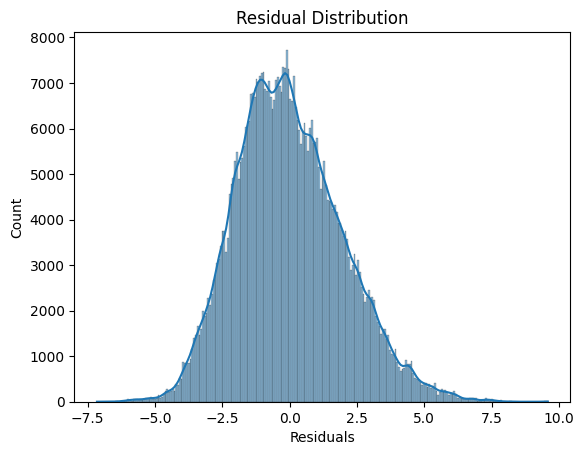

In [59]:
# Model Evaluation: Residual analysis
import seaborn as sns

residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residuals")
plt.show()

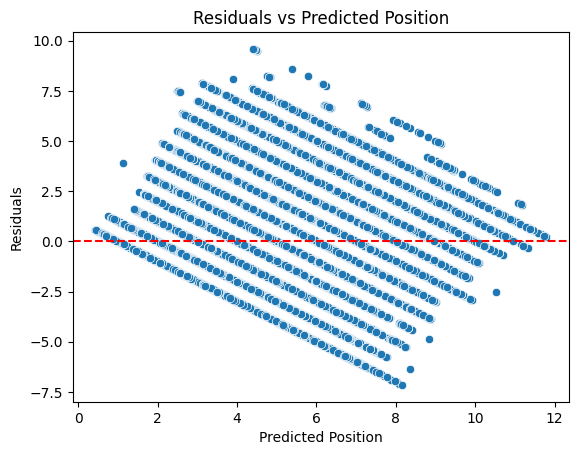

In [61]:
# Model Evaluation: Residuals vs. Predictions
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Position")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Position")
plt.show()

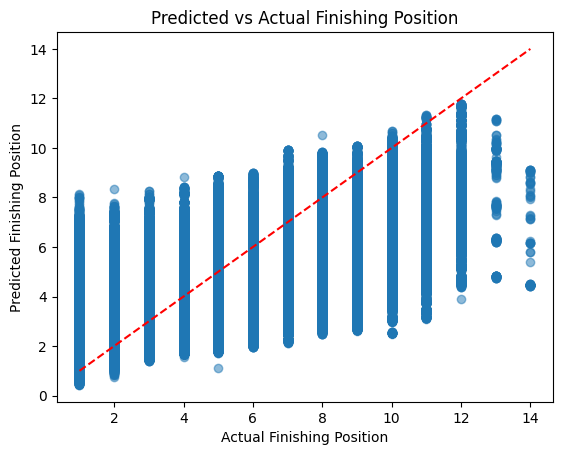

In [63]:
# Model Evaluation: Predicted vs. Actual
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual Finishing Position")
plt.ylabel("Predicted Finishing Position")
plt.title("Predicted vs Actual Finishing Position")
plt.show()